In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
def metric_name(x):
    if x['name_l'] == 'MSE':
        return "$\mu{-risk}$"
    elif x['name_l'] == 'R2':
        return "$\mu{-risk}_R$"
    elif x['name_l'] == 'Oracle':
        return 'Oracle'
    elif x['name_l'] == 'policy':
        return "$\mathcal{R}_{pol}$"
    else:
        ret = "$\\tau{-risk}"
        if x['name_l'].startswith('rscore'):
            bl = x['name_l'].split('_')[1].upper()
            ret += "_{R}$"
            ret += f' ({bl})'
        elif x['name_l'].startswith('match'):
            spl = x['name_l'].split('_')
            ret += "_{match}^{"
            ret += spl[1].upper()
            ret += "}$"
            ret += f' (k={spl[2]})'
        elif x['name_l'].startswith('plugin'):
            spl = x['name_l'].split('_')
            if len(spl[-1]) > 1: # plugin
                ret += "_{plug}^{"
                ret += spl[1].upper()
                ret += "}$"
                ret += f' ({spl[2].upper()}-{spl[3].upper()})'
            else: # matching pehe (fixing the mistake in table generation)
                ret += "_{match}^{"
                ret += spl[1].upper()
                ret += "}$"
                ret += f' (k={spl[2]})'
        
        return ret

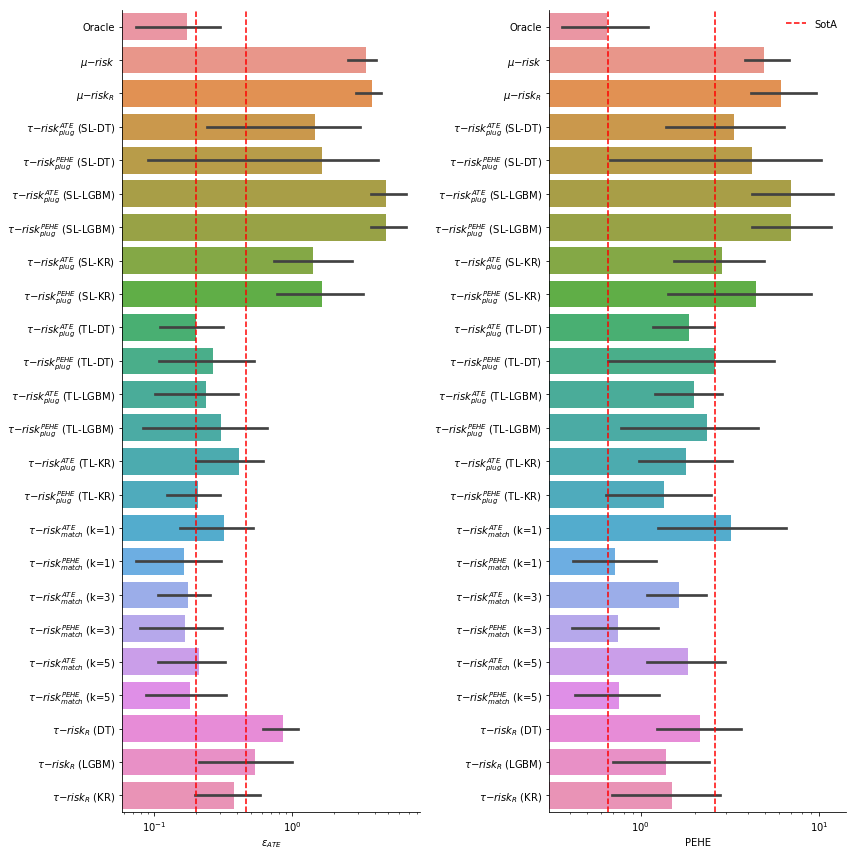

In [34]:
ds = 'ihdp'
avg_metric = 'ate'
ite_metric = 'pehe'

df = pd.read_csv(f'./tables/{ds}_compare_metrics_val_iter.csv')
df['metric'] = df.apply(metric_name, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 12))

ax = axs[0]
sns.barplot(data=df, y='metric', x=avg_metric, orient='h', ax=ax)
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('')
ax.axvline(0.2, ls='dashed', label='SotA', c='r')
ax.axvline(0.46, ls='dashed', label='SotA', c='r')
ax.set_xscale('log')
sns.despine(top=True, right=True, ax=ax)

ax = axs[1]
sns.barplot(data=df, y='metric', x=ite_metric, orient='h', ax=ax)
ax.set_xlabel('PEHE')
ax.set_ylabel('')
ax.axvline(0.656, ls='dashed', label='SotA', c='r')
ax.axvline(2.6, ls='dashed', c='r')
ax.set_xscale('log')
sns.despine(top=True, right=True, ax=ax)

plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('metrics_iter_ihdp.pdf', dpi=1000)

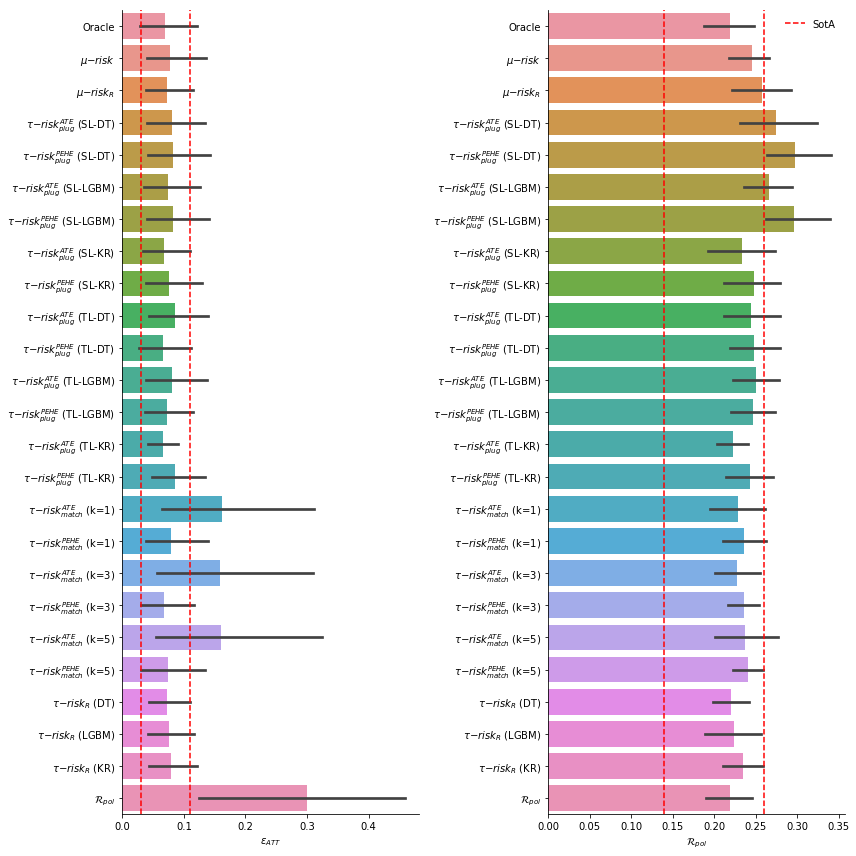

In [38]:
ds = 'jobs'
avg_metric = 'att'
ite_metric = 'policy'

df = pd.read_csv(f'./tables/{ds}_compare_metrics_val_iter.csv')
df['metric'] = df.apply(metric_name, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 12))

ax = axs[0]
sns.barplot(data=df, y='metric', x=avg_metric, orient='h', ax=ax)
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_ylabel('')
ax.axvline(0.03, ls='dashed', label='SotA', c='r')
ax.axvline(0.11, ls='dashed', label='SotA', c='r')
#ax.set_xscale('log')
sns.despine(top=True, right=True, ax=ax)

ax = axs[1]
sns.barplot(data=df, y='metric', x=ite_metric, orient='h', ax=ax)
ax.set_xlabel('$\mathcal{R}_{pol}$')
ax.set_ylabel('')
ax.axvline(0.14, ls='dashed', label='SotA', c='r')
ax.axvline(0.26, ls='dashed', c='r')
#ax.set_xscale('log')
sns.despine(top=True, right=True, ax=ax)

plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('metrics_iter_jobs.pdf', dpi=1000)

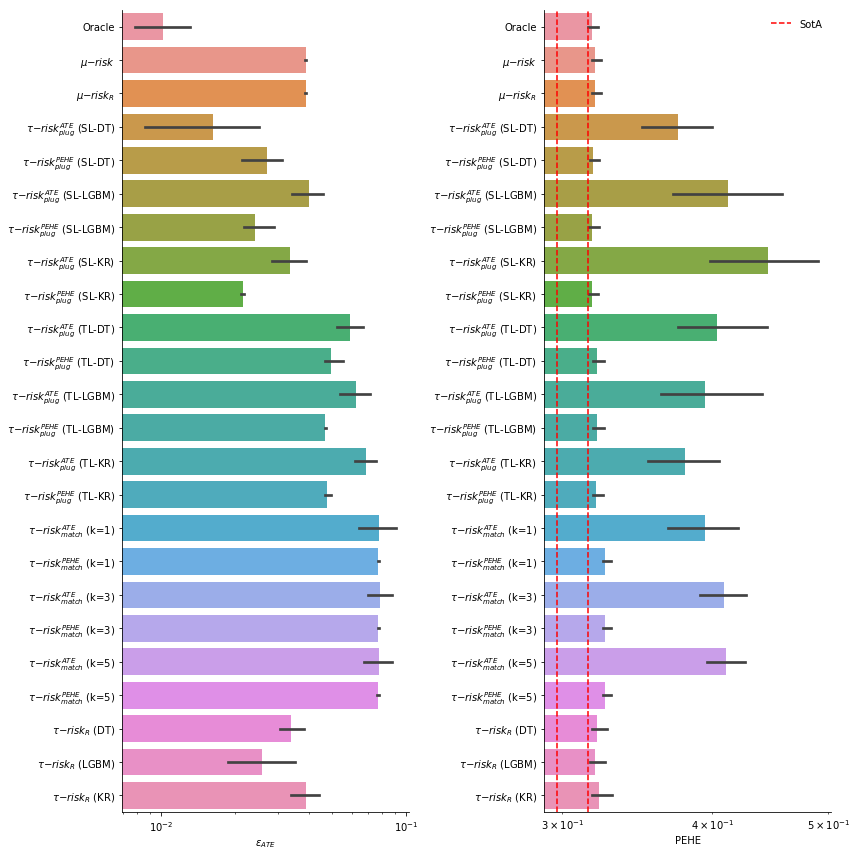

In [39]:
ds = 'twins'
avg_metric = 'ate'
ite_metric = 'pehe'

df = pd.read_csv(f'./tables/{ds}_compare_metrics_val_iter.csv')
df['metric'] = df.apply(metric_name, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 12))

ax = axs[0]
sns.barplot(data=df, y='metric', x=avg_metric, orient='h', ax=ax)
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('')
#ax.axvline(0.2, ls='dashed', label='SotA', c='r')
#ax.axvline(0.46, ls='dashed', label='SotA', c='r')
ax.set_xscale('log')
sns.despine(top=True, right=True, ax=ax)

ax = axs[1]
sns.barplot(data=df, y='metric', x=ite_metric, orient='h', ax=ax)
ax.set_xlabel('PEHE')
ax.set_ylabel('')
ax.axvline(0.297, ls='dashed', label='SotA', c='r')
ax.axvline(0.315, ls='dashed', c='r')
ax.set_xscale('log')
sns.despine(top=True, right=True, ax=ax)

plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('metrics_iter_twins.pdf', dpi=1000)

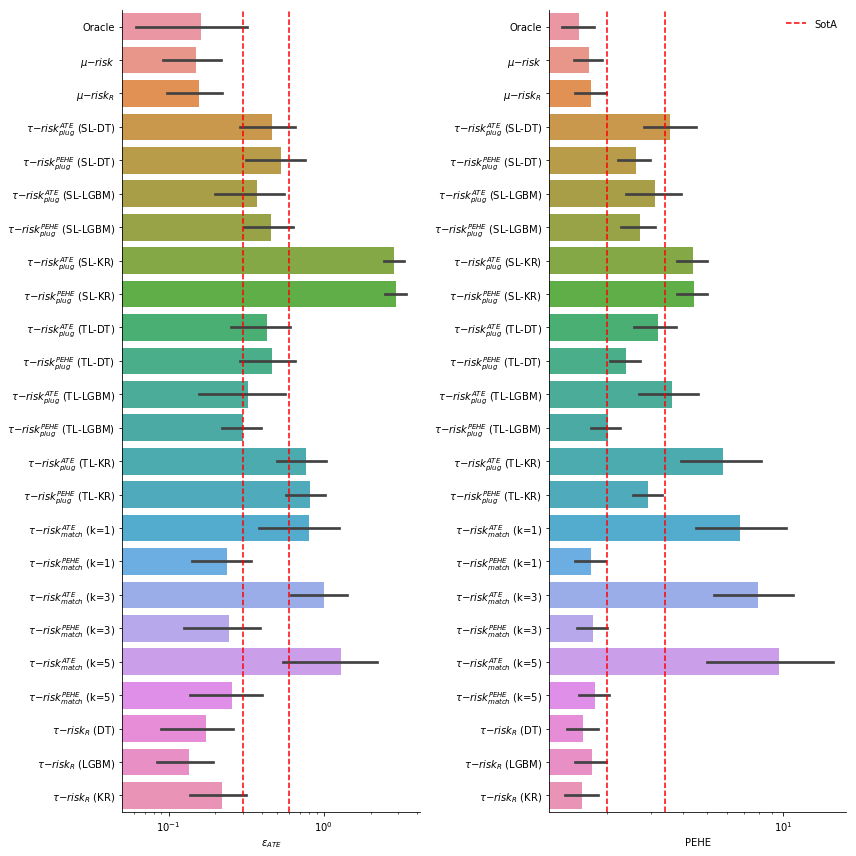

In [40]:
ds = 'news'
avg_metric = 'ate'
ite_metric = 'pehe'

df = pd.read_csv(f'./tables/{ds}_compare_metrics_val_iter.csv')
df['metric'] = df.apply(metric_name, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(12, 12))

ax = axs[0]
sns.barplot(data=df, y='metric', x=avg_metric, orient='h', ax=ax)
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('')
ax.axvline(0.3, ls='dashed', label='SotA', c='r')
ax.axvline(0.6, ls='dashed', label='SotA', c='r')
ax.set_xscale('log')
sns.despine(top=True, right=True, ax=ax)

ax = axs[1]
sns.barplot(data=df, y='metric', x=ite_metric, orient='h', ax=ax)
ax.set_xlabel('PEHE')
ax.set_ylabel('')
ax.axvline(2.0, ls='dashed', label='SotA', c='r')
ax.axvline(3.4, ls='dashed', c='r')
ax.set_xscale('log')
sns.despine(top=True, right=True, ax=ax)

plt.legend(loc='upper right', frameon=False, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('metrics_iter_news.pdf', dpi=1000)